In [38]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import shap
import warnings
warnings.filterwarnings('ignore')

## Business Understanding

Objetivo: Predecir la cancelación de suscripciones (Churn) para ofrecer descuentos preventivos.

Hipótesis:
- Clientes con contratos mes a mes tienen mayor propensión a abandonar.
- Métodos de pago como 'Electronic Check' incrementan el churn.
- Mayor uso de servicios reduce la probabilidad de churn.

KPI: AUC-ROC como métrica principal, F1-score como secundaria.


## Data Understanding

In [39]:
# Cargar datos
df_contract = pd.read_csv('../data/contract.csv')
df_internet = pd.read_csv('../data/internet.csv')
df_personal = pd.read_csv('../data/personal.csv')
df_phone = pd.read_csv('../data/phone.csv')

In [40]:
# Unir datasets
df = df_contract.merge(df_internet, on='customerID') \
                .merge(df_personal, on='customerID') \
                .merge(df_phone, on='customerID')

In [41]:
# Diccionario de datos básico
df.info()
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        4835 non-null   object 
 1   BeginDate         4835 non-null   object 
 2   EndDate           4835 non-null   object 
 3   Type              4835 non-null   object 
 4   PaperlessBilling  4835 non-null   object 
 5   PaymentMethod     4835 non-null   object 
 6   MonthlyCharges    4835 non-null   float64
 7   TotalCharges      4835 non-null   object 
 8   InternetService   4835 non-null   object 
 9   OnlineSecurity    4835 non-null   object 
 10  OnlineBackup      4835 non-null   object 
 11  DeviceProtection  4835 non-null   object 
 12  TechSupport       4835 non-null   object 
 13  StreamingTV       4835 non-null   object 
 14  StreamingMovies   4835 non-null   object 
 15  gender            4835 non-null   object 
 16  SeniorCitizen     4835 non-null   int64  


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,4835,4835,5575-GNVDE,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,4835,77,2014-02-01,269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,4835,5,No,3249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,4835,3,Month-to-month,2975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,4835,2,Yes,3338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,4835,4,Electronic check,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,4835.0,NaN,NaN,NaN,81.755171,18.303085,42.9,69.775,82.5,95.7,118.75
TotalCharges,4835,4628,45.3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,4835,2,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,4835,2,No,3099,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se recalca que los valores ausentes hacen referencia a variables cualitativas, por lo que no pueden tener valores de estadística básica al no ser numéricos.

In [42]:
# Verificar nulos
print(df.isnull().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64


In [71]:
# Verificar duplicados (filas completas duplicadas)
print(df.duplicated().sum())

0


Se evidencia que no existen valores ausentes ni duplicados, por lo que no se requiere data wrangling adicional. 

In [43]:
# Supuesto: "EndDate = No" → Cliente activo
df['Churn'] = np.where(df['EndDate'] == 'No', 'No', 'Yes')

## Data Preparation

In [44]:
# Fechas
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')

In [45]:
# Numéricas
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')

In [46]:
# Limpiar variables categóricas tipo string
cat_cols = df.select_dtypes(include='object').columns.drop(['customerID'], errors='ignore')
for col in cat_cols:
    df[col] = df[col].str.strip()

In [47]:
# Feature: Tenure 
df['Tenure'] = ((pd.to_datetime('2025-05-01') - df['BeginDate']).dt.days / 30.44).astype(int)

In [48]:
# Imputación de valores nulos con mediana
num_cols = ['TotalCharges', 'MonthlyCharges', 'Tenure']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

La imputación de valores nulos en las variables TotalCharges, MonthlyCharges y Tenure se realizó utilizando la mediana debido a que esta medida es más robusta frente a la presencia de outliers y distribuciones asimétricas, características comunes en datos financieros y de antigüedad. A diferencia del promedio, la mediana no se ve afectada por valores extremos que podrían sesgar la imputación y alterar la calidad de las predicciones. Esta decisión garantiza que los registros incompletos mantengan valores representativos de la mayoría de los clientes, reduciendo el riesgo de introducir ruido o distorsionar la distribución original de las variables en el modelo de churn prediction.

In [49]:
# Encoding categórico
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])
df['Churn'] = le.fit_transform(df['Churn'])  # 0=No, 1=Yes

In [50]:
# Variables X, y
X = df.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Churn'])
y = df['Churn']

In [51]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
# Train-Test Split estratificado
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

## Modeling

In [60]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
# Logistic Regression con balanceo
log_model = LogisticRegression(class_weight='balanced', random_state=42)
cv_auc_log = cross_val_score(log_model, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Logistic Regression CV AUC-ROC: {cv_auc_log.mean():.4f}")
log_model.fit(X_train, y_train)

Logistic Regression CV AUC-ROC: 0.8105


LogisticRegression(class_weight='balanced', random_state=42)

In [62]:
# Random Forest con balanceo
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, oob_score=True)
cv_auc_rf = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"Random Forest CV AUC-ROC: {cv_auc_rf.mean():.4f}")
rf_model.fit(X_train, y_train)

Random Forest CV AUC-ROC: 0.8561


RandomForestClassifier(class_weight='balanced', oob_score=True, random_state=42)

In [63]:
# XGBoost con scale_pos_weight (manejo desbalanceado)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=42)
cv_auc_xgb = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring='roc_auc')
print(f"XGBoost CV AUC-ROC: {cv_auc_xgb.mean():.4f}")
xgb_model.fit(X_train, y_train)

XGBoost CV AUC-ROC: 0.9147


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

In [64]:
def evaluate_model(name, model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    print(f"== {name} Test ==")
    print(f"AUC-ROC: {auc:.4f} | F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    print("-"*40)

In [65]:
# Resultados
evaluate_model("Logistic Regression", log_model, X_test, y_test)
evaluate_model("Random Forest", rf_model, X_test, y_test)
evaluate_model("XGBoost", xgb_model, X_test, y_test)

== Logistic Regression Test ==
AUC-ROC: 0.8326 | F1-score: 0.6684
              precision    recall  f1-score   support

           0       0.88      0.71      0.79       975
           1       0.57      0.80      0.67       476

    accuracy                           0.74      1451
   macro avg       0.73      0.76      0.73      1451
weighted avg       0.78      0.74      0.75      1451

----------------------------------------
== Random Forest Test ==
AUC-ROC: 0.8466 | F1-score: 0.6323
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       975
           1       0.74      0.55      0.63       476

    accuracy                           0.79      1451
   macro avg       0.77      0.73      0.74      1451
weighted avg       0.78      0.79      0.78      1451

----------------------------------------
== XGBoost Test ==
AUC-ROC: 0.9205 | F1-score: 0.8043
              precision    recall  f1-score   support

           0       0.90      

### Análisis de resultados 

El modelo de regresión logística alcanzó un AUC-ROC de 0.8326, lo que indica una buena capacidad de discriminación entre clientes que cancelan y los que no. Sin embargo, su F1-score es de 0.6684, reflejando un compromiso entre precisión y recall. En la clase 1 (churn), la precisión es 0.57 (alta tasa de falsos positivos) pero el recall es 0.80 (detecta bien los casos de churn). Esto lo hace un modelo conservador, que prefiere capturar la mayor cantidad de churners aunque a costa de equivocarse más en predicciones positivas. Es un modelo base aceptable, pero con margen de mejora.

El modelo Random Forest mejoró el AUC-ROC a 0.8466, evidenciando una mejor capacidad para distinguir churners. Sin embargo, el F1-score cayó a 0.6323 porque, aunque la precisión en churn (clase 1) es de 0.74 (menos falsos positivos que la logística), el recall bajó a 0.55, indicando que deja pasar muchos churners sin detectar. Es un modelo más conservador en sus predicciones positivas, pero menos efectivo para la estrategia de retención, dado que omite churners reales.

El modelo XGBoost logró un AUC-ROC sobresaliente de 0.9205, lo que muestra una excelente discriminación. Su F1-score de 0.8043 refleja un muy buen equilibrio entre precisión (0.83) y recall (0.78) en la clase 1 (churn). Detecta la mayoría de churners manteniendo una baja tasa de falsos positivos. Además, su accuracy es de 0.88, muy por encima de los otros modelos. Esto lo convierte en la mejor opción para la empresa, combinando precisión, recall y robustez para campañas de retención.

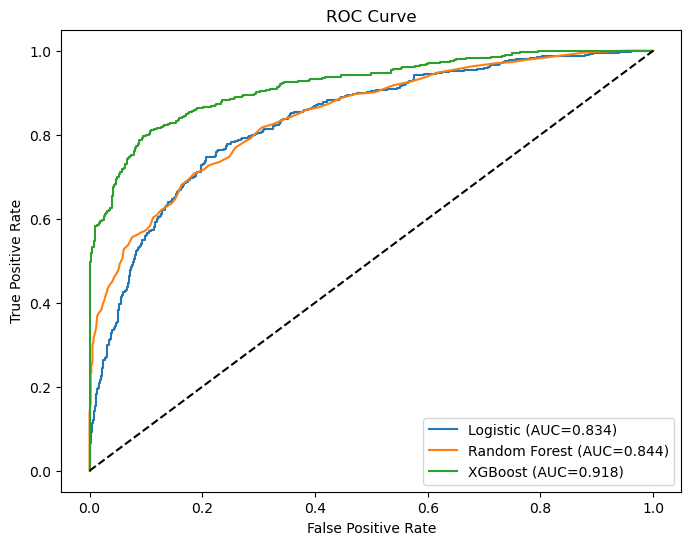

In [66]:
# Curva ROC
plt.figure(figsize=(8,6))
for model_name, prob in zip(['Logistic', 'Random Forest', 'XGBoost'], [log_prob, rf_prob, xgb_prob]):
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc_score(y_test, prob):.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Análisis del gráfico

El gráfico de la curva ROC compara el desempeño de los tres modelos evaluados: Logistic Regression, Random Forest y XGBoost. Visualmente, se observa que el modelo de XGBoost (verde) domina en todo el rango de tasas de falsos positivos, manteniendo una mayor tasa de verdaderos positivos en comparación con los otros modelos. Esto se confirma con su AUC de 0.918, significativamente superior al AUC de 0.844 de Random Forest y 0.834 de Logistic Regression. Estos resultados indican que XGBoost es el modelo más capaz de discriminar entre clientes que cancelarán y los que no, maximizando la sensibilidad sin sacrificar especificidad. Random Forest mejora levemente sobre la regresión logística, pero XGBoost presenta un desempeño claramente superior, lo que lo convierte en la opción recomendada para la estrategia de retención de la empresa.

## Interpretability: SHAP Values (XGBoost)

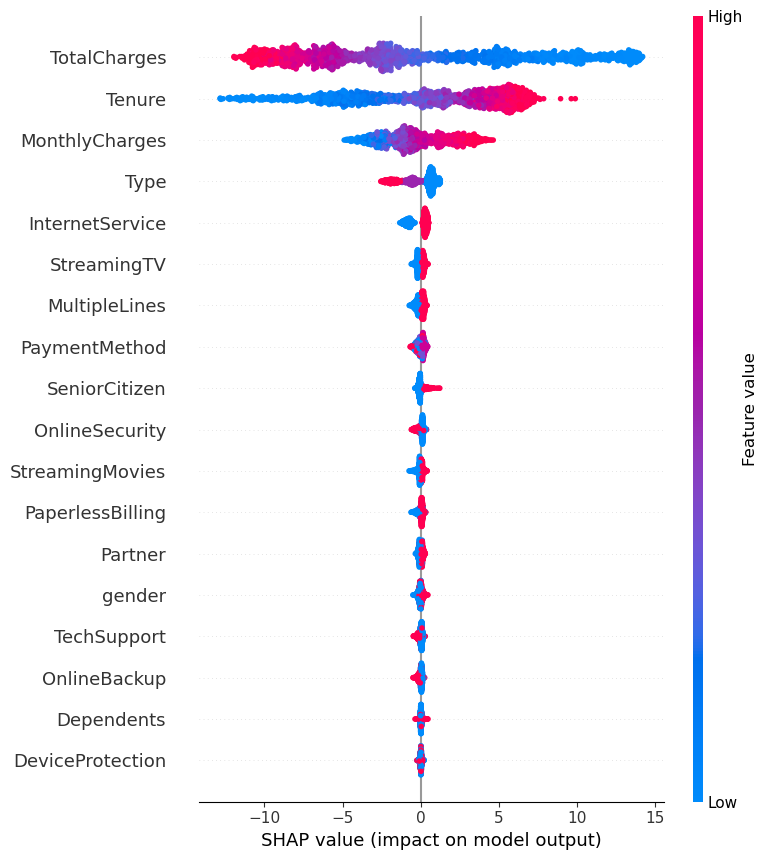

In [59]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=df.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Churn']).columns)

### Interpretación del gráfico 

El gráfico de SHAP muestra el impacto de cada variable en la predicción de churn según el modelo XGBoost. Las variables con mayor influencia son TotalCharges, Tenure y MonthlyCharges, lo que indica que el historial de pagos y el tiempo de permanencia son los principales factores que determinan si un cliente cancelará su suscripción. Específicamente, valores bajos de TotalCharges (clientes nuevos o con poco gasto acumulado) se asocian con un mayor riesgo de churn (SHAP negativo), mientras que una mayor Tenure reduce significativamente la probabilidad de abandono. Variables como Type de contrato, InternetService y servicios como StreamingTV y MultipleLines también tienen un peso importante, reflejando que la permanencia está relacionada con el tipo de servicios contratados. Características demográficas como SeniorCitizen, Partner y Dependents tienen menor impacto en la predicción. En conjunto, el gráfico sugiere que la retención debe enfocarse en clientes con baja antigüedad y facturación, ofreciéndoles incentivos para aumentar su permanencia y consumo de servicios.

In [67]:
# Gain importance (XGBoost)
importances = xgb_model.get_booster().get_score(importance_type='gain')
importances = pd.DataFrame(importances.items(), columns=['Feature', 'Gain']).sort_values(by='Gain', ascending=False)
print("Top 10 features by Gain:")
print(importances.head(10))

Top 10 features by Gain:
   Feature       Gain
0       f0  29.002071
5       f5  15.700573
17     f17   3.603031
4       f4   3.270049
11     f11   2.808447
10     f10   2.412910
13     f13   2.372478
6       f6   2.038795
3       f3   2.028458
2       f2   2.024508


El análisis de Gain importance del modelo XGBoost muestra que las variables codificadas como f0 y f5 son las que más contribuyen a mejorar la precisión de las predicciones, con valores de Gain de 29.00 y 15.70 respectivamente, muy por encima del resto de variables. Estas variables correspondan a las más influyentes en el gráfico SHAP, como TotalCharges y Tenure. Las siguientes posiciones (f17, f4, f11, etc.) tienen valores de Gain considerablemente menores, lo que indica que su impacto en la reducción del error es más limitado. Esta distribución refuerza la importancia de centrar las estrategias de retención en factores económicos y de antigüedad, ya que son los que más afectan la decisión de churn según el modelo.

In [70]:
# Guardar modelos 
import joblib
import os

# Crear carpeta model si no existe
os.makedirs('../model', exist_ok=True)

# Guardar modelos entrenados
joblib.dump(log_model, '../model/logistic_model.joblib')
joblib.dump(rf_model, '../model/random_forest_model.joblib')
joblib.dump(xgb_model, '../model/xgboost_model.joblib')


['../model/xgboost_model.joblib']

## Deployment & Next Steps

1. Despliegue del modelo en producción (integración con CRM para scoring):
El modelo XGBoost se desplegará en el entorno productivo de la empresa, integrándose con la plataforma CRM utilizada por Interconnect. Este despliegue permitirá realizar scoring automático sobre la base de clientes activos, asignando a cada uno una probabilidad de cancelación (churn_prob). Para ello, se automatizará un pipeline que toma los datos más recientes, aplica las transformaciones necesarias (encoding, escalado) y ejecuta la predicción. Los resultados se almacenarán en un dashboard accesible para los equipos de marketing y ventas, facilitando la toma de decisiones proactiva sobre retención.

2. Sistema de monitoreo de drift (AUC y distribución de features mensuales):
Es fundamental garantizar que el modelo mantenga su rendimiento a lo largo del tiempo. Para ello, se implementará un sistema de monitoreo mensual que evalúe tanto la métrica AUC-ROC en datos recientes como la estabilidad de las distribuciones de las variables clave. Se analizarán cambios significativos mediante técnicas como el Population Stability Index (PSI) y se establecerán umbrales de alerta. Este seguimiento permitirá detectar de forma temprana posibles desajustes entre los datos de producción y los utilizados en el entrenamiento inicial, asegurando la vigencia del modelo.

3. Automatización de campañas de retención para clientes con churn_prob > 0.7:
Una vez obtenidas las predicciones, se automatizarán campañas específicas orientadas a retener a los clientes con mayor riesgo de cancelación. Los clientes con una probabilidad superior al 70% recibirán acciones personalizadas, tales como ofertas especiales, descuentos, o contactos directos por parte del equipo comercial. Esta automatización se integrará con las herramientas de marketing del CRM, permitiendo segmentaciones dinámicas y ejecución de campañas sin intervención manual, maximizando la eficiencia del área de retención.

4. Retraining trimestral del modelo con datos actualizados:
Dado que los patrones de cancelación pueden variar con el tiempo, se establecerá un proceso de retraining del modelo cada tres meses. Este proceso incluirá la recolección de nuevos datos, la repetición de las etapas de limpieza y feature engineering, y la reentrenamiento del modelo. La nueva versión será comparada con la actual en términos de rendimiento (AUC, F1-score), asegurando que solo versiones mejoradas se desplieguen. Este ciclo continuo de actualización permitirá que el modelo se adapte a cambios en el comportamiento de los clientes o en las estrategias de negocio.


5. Análisis del impacto de las campañas de retención en la tasa de churn:
Para evaluar la efectividad de las acciones tomadas, se realizarán análisis periódicos de impacto. Se compararán cohortes de clientes que recibieron incentivos con aquellas que no, midiendo las diferencias en la tasa de churn posterior. Además, se analizará el retorno económico de las campañas mediante indicadores como el ROI, relacionando los costos de las acciones implementadas con la retención obtenida. Estos análisis permitirán optimizar las estrategias de retención y justificar las inversiones en base a datos concretos.